# Pipeline Demo

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
%matplotlib inline


In [2]:
import sklearn
print(f"Scikit-learn version: {sklearn.__version__}")

Scikit-learn version: 1.4.2


In [3]:
from sklearn.model_selection import train_test_split

In [4]:
##column transformers to organize the pipelines
from sklearn.compose import ColumnTransformer
##make_pipeline to create a pipeline based on Function transformers
from sklearn.pipeline import make_pipeline
##StandardScaler to scale the numerical features
from sklearn.preprocessing import StandardScaler
##and function transformer to apply the discretizer
from sklearn.preprocessing import FunctionTransformer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder

In [5]:
from sklearn.pipeline import Pipeline


In [6]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_score, recall_score, accuracy_score

In [7]:
import skopt
print(f"Scikit-optimize version: {skopt.__version__}")
from skopt import BayesSearchCV

Scikit-optimize version: 0.10.2


In [8]:
from sklearn.neural_network import MLPClassifier

In [9]:
import joblib

In [10]:
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Scikit-optimize version: {skopt.__version__}")
print(f"Joblib version: {joblib.__version__}")

Pandas version: 2.2.2
Numpy version: 1.25.2
Seaborn version: 0.13.2
Scikit-learn version: 1.4.2
Scikit-optimize version: 0.10.2
Joblib version: 1.2.0


In [11]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

Also we need imblearn

In [12]:
import imblearn
print(f"Imbalanced-learn version: {imblearn.__version__}")

Imbalanced-learn version: 0.11.0


In [13]:
from imblearn.over_sampling import BorderlineSMOTE

# 1. Get Data

In [14]:
def download_kaggle_dataset(dataset):
    api = KaggleApi()
    api.authenticate()
    print("Kaggle API authenticated successfully.")

    # Create a directory to store the data
    data_dir = 'kaggle_covid_data'
    os.makedirs(data_dir, exist_ok=True)
    print(f"Directory '{data_dir}' created or already exists.")

    # Print the current working directory
    print(f"Current working directory: {os.getcwd()}")

    # Download the dataset
    print(f"Downloading dataset: {dataset}")
    api.dataset_download_files(dataset, path=data_dir, unzip=True)
    print("Dataset downloaded and unzipped successfully.")

    # List the contents of the directory
    print(f"Contents of '{data_dir}': {os.listdir(data_dir)}")

# Use the function defined above to download the dataset
# It is sufficient to use the dataset identifier found in the dataset URL
download_kaggle_dataset('meirnizri/covid19-dataset/')

Kaggle API authenticated successfully.
Directory 'kaggle_covid_data' created or already exists.
Current working directory: /Users/andreibleahu/ML-Covid-Predictions/notebooks
Dataset downloaded and unzipped successfully.
Contents of 'kaggle_covid_data': ['Covid Data.csv']


Alternatively, the dataset is found [here](https://www.kaggle.com/datasets/meirnizri/covid19-dataset/).

In [15]:
covid_df = pd.read_csv('kaggle_covid_data/Covid Data.csv')

In [16]:
covid_df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


# 2. Clean Data

In [17]:
# get clean data
def get_clean_data(df):

    """ Function that implements the important cleaning operations on the dataset
    df: the dataset to be cleaned"""

    # List of conditions
    conditions = ['USMER', 'INTUBED', 'PNEUMONIA',  'PREGNANT', 
              'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
              'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
              'RENAL_CHRONIC', 'TOBACCO', 'ICU']
    
    #replace "2" with 0 in categorical columns that show the presence of a symptom
    for condition in conditions:
        df[condition] = df[condition].replace(2, 0)

    # Deal with 'SEX' column
    df["SEX"] = df['SEX'].astype('string')
    df['SEX'] = df['SEX'].replace({"1": 'Female', "2": 'Male'})

    # Deal with 'PATIENT_TYPE' column
    df["PATIENT_TYPE"] = df['PATIENT_TYPE'].astype('string')
    df['PATIENT_TYPE'] = df['PATIENT_TYPE'].replace({"1": 'Home', "2": 'Hospital'})

    # Create response variables
    df["Lower_Risk"] = df["DATE_DIED"].apply(lambda x: 1 if x == "9999-99-99" else 0)
    df["Higher_Risk"] = df["DATE_DIED"].apply(lambda x: 1 if x != "9999-99-99" else 0)

    # Replace 97, 98, 99 with NaN
    df = df.replace({97: np.nan, 98: np.nan, 99: np.nan})

    # Impute median for age
    df['AGE'] = df['AGE'].fillna(df['AGE'].mean())

    # missing feats
    mis_features = [ 'PNEUMONIA', 'DIABETES', 'COPD', 'ASTHMA',
       'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'ICU', 'PREGNANT', 'INTUBED']
    
    # Impute 0.5 for missing values
    for col in mis_features:
        df[col] = df[col].fillna(0.5)

    # Select positive cases
    df['COVID_POSITIVE'] = df['CLASIFFICATION_FINAL'].apply(lambda x: 1 if x<=3 else 0)
    df['COVID_INCONCLUSIVE'] = df['CLASIFFICATION_FINAL'].apply(lambda x: 1 if x>=4 else 0)

    # create new dataframe only with positive
    df_positive = df[df['COVID_POSITIVE'] == 1]

    # Drop columns
    df_positive = df_positive.drop(['COVID_POSITIVE', 'COVID_INCONCLUSIVE', 'DATE_DIED', 'Lower_Risk'], axis=1)


    return df_positive


In [18]:
clean_covid = get_clean_data(covid_df)

In [19]:
clean_covid.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,...,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU,Higher_Risk
0,0,1,Female,Home,0.5,1.0,65.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,0.5,1
2,0,1,Male,Hospital,1.0,0.0,55.0,0.5,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.0,1
4,0,1,Male,Home,0.5,0.0,68.0,0.5,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,0.5,1
5,0,1,Female,Hospital,0.0,1.0,40.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.0,0
6,0,1,Female,Home,0.5,0.0,64.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.5,0


In [20]:
clean_covid.columns

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'INTUBED', 'PNEUMONIA',
       'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU',
       'Higher_Risk'],
      dtype='object')

In [21]:
clean_covid['PATIENT_TYPE'].info()

<class 'pandas.core.series.Series'>
Index: 391979 entries, 0 to 1047937
Series name: PATIENT_TYPE
Non-Null Count   Dtype 
--------------   ----- 
391979 non-null  string
dtypes: string(1)
memory usage: 6.0 MB


# 3. Split the Data

In [22]:
train, test = train_test_split(clean_covid, test_size=0.2, stratify =clean_covid['Higher_Risk'], random_state=1923)

In [23]:
train 

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,...,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU,Higher_Risk
446648,0,12,Female,Hospital,0.0,1.0,68.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3,0.0,1
582398,0,12,Female,Home,0.5,0.0,23.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.5,0
629289,0,12,Male,Home,0.5,0.0,22.0,0.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.5,0
585391,1,12,Male,Hospital,0.0,1.0,69.0,0.5,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,0.0,0
573687,0,12,Male,Hospital,0.0,0.0,52.0,0.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527538,0,12,Male,Home,0.5,0.0,42.0,0.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.5,0
567736,0,12,Male,Home,0.5,0.0,57.0,0.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.5,0
121787,0,4,Male,Hospital,0.0,0.0,50.0,0.5,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,3,0.0,0
544777,1,12,Male,Home,0.5,0.0,47.0,0.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.5,0


In [24]:
test 

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,...,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU,Higher_Risk
439196,0,11,Male,Hospital,1.0,1.0,46.0,0.5,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,1.0,1
79519,1,4,Male,Hospital,0.0,0.0,27.0,0.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.0,0
402675,0,9,Male,Hospital,0.0,0.0,71.0,0.5,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,0.0,0
465637,1,12,Female,Hospital,0.0,1.0,72.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,0.0,1
515014,1,12,Female,Hospital,1.0,1.0,8.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573811,1,12,Male,Home,0.5,0.0,48.0,0.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3,0.5,0
21929,1,4,Female,Hospital,0.0,1.0,86.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.0,1
638509,0,12,Female,Home,0.5,0.0,58.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,0.5,0
41946,1,4,Male,Hospital,1.0,1.0,64.0,0.5,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,3,0.0,1


# 4. Pre-process

## Custom Class

In [25]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        ## Apply your transformation
        return X.astype(str)

    def get_feature_names_out(self, input_features=None):
        ## Implement this method to return the feature names
        return input_features

## Preprocessor

In [26]:
##this creates a pipeline that transforms to string then does one-hot encoding
cat_pipeline_default = make_pipeline(
                CustomTransformer(),
                OneHotEncoder(handle_unknown='ignore')
                ) 

##this creates a pipeline that only does one-hot encoding
cat_pipeline = make_pipeline(
                OneHotEncoder(handle_unknown='ignore')
                )

##Now I am creating two pipelines for discretizing, and one-hot-encoding.

bucket_pipeline_1 = make_pipeline(
    KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='kmeans', subsample = 200_000, random_state=41),
     OneHotEncoder(handle_unknown='ignore')) 


## now for standard scaling
num_pipeline = make_pipeline(
    StandardScaler()
)


preprocessor = ColumnTransformer([
        
        ('categorical', cat_pipeline_default, ['USMER', 'INTUBED', 'PNEUMONIA', 'PREGNANT', 'DIABETES', 'COPD',
        'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR',
        'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'ICU']),
        ('numerical', num_pipeline, ['AGE']),
        ('categorical simple', cat_pipeline, ['SEX', 'PATIENT_TYPE']),
         ('drop', 'drop', ['CLASIFFICATION_FINAL', 'MEDICAL_UNIT']), # we do not need medical_unit
    ], remainder='passthrough')

In [27]:
XTrain = train.drop('Higher_Risk', axis=1)
XTrain

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
446648,0,12,Female,Hospital,0.0,1.0,68.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3,0.0
582398,0,12,Female,Home,0.5,0.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.5
629289,0,12,Male,Home,0.5,0.0,22.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.5
585391,1,12,Male,Hospital,0.0,1.0,69.0,0.5,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,0.0
573687,0,12,Male,Hospital,0.0,0.0,52.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527538,0,12,Male,Home,0.5,0.0,42.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.5
567736,0,12,Male,Home,0.5,0.0,57.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.5
121787,0,4,Male,Hospital,0.0,0.0,50.0,0.5,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,3,0.0
544777,1,12,Male,Home,0.5,0.0,47.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.5


In [28]:
XTrain.isnull().sum()

USMER                   0
MEDICAL_UNIT            0
SEX                     0
PATIENT_TYPE            0
INTUBED                 0
PNEUMONIA               0
AGE                     0
PREGNANT                0
DIABETES                0
COPD                    0
ASTHMA                  0
INMSUPR                 0
HIPERTENSION            0
OTHER_DISEASE           0
CARDIOVASCULAR          0
OBESITY                 0
RENAL_CHRONIC           0
TOBACCO                 0
CLASIFFICATION_FINAL    0
ICU                     0
dtype: int64

In [29]:
XTest = test.drop('Higher_Risk', axis=1)
XTest

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
439196,0,11,Male,Hospital,1.0,1.0,46.0,0.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,1.0
79519,1,4,Male,Hospital,0.0,0.0,27.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.0
402675,0,9,Male,Hospital,0.0,0.0,71.0,0.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,0.0
465637,1,12,Female,Hospital,0.0,1.0,72.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,0.0
515014,1,12,Female,Hospital,1.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573811,1,12,Male,Home,0.5,0.0,48.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3,0.5
21929,1,4,Female,Hospital,0.0,1.0,86.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.0
638509,0,12,Female,Home,0.5,0.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,0.5
41946,1,4,Male,Hospital,1.0,1.0,64.0,0.5,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,3,0.0


In [30]:
yTrain = train['Higher_Risk']
yTrain 

446648    1
582398    0
629289    0
585391    0
573687    0
         ..
527538    0
567736    0
121787    0
544777    0
492124    0
Name: Higher_Risk, Length: 313583, dtype: int64

In [31]:
yTest = test['Higher_Risk']
yTest

439196    1
79519     0
402675    0
465637    1
515014    0
         ..
573811    0
21929     1
638509    0
41946     1
148142    0
Name: Higher_Risk, Length: 78396, dtype: int64

Fit preprocessor on training data and save

In [32]:
preprocessor.fit(XTrain)

ColumnTransformer(remainder='passthrough',
                  transformers=[('categorical',
                                 Pipeline(steps=[('customtransformer',
                                                  CustomTransformer()),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['USMER', 'INTUBED', 'PNEUMONIA', 'PREGNANT',
                                  'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
                                  'HIPERTENSION', 'OTHER_DISEASE',
                                  'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC',
                                  'TOBACCO', 'ICU']),
                                ('numerical',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['AGE']),
                                ('categorical simple',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['SEX', 'PATIENT_TYPE']),
                                ('drop', 'drop',
                                 ['CLASIFFICATION_FINAL', 'MEDICAL_UNIT'])])

In [33]:
# save fitted preprocessor
joblib.dump(preprocessor, 'preprocessor.pkl')

['preprocessor.pkl']

In [34]:
preprocessor 

ColumnTransformer(remainder='passthrough',
                  transformers=[('categorical',
                                 Pipeline(steps=[('customtransformer',
                                                  CustomTransformer()),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['USMER', 'INTUBED', 'PNEUMONIA', 'PREGNANT',
                                  'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
                                  'HIPERTENSION', 'OTHER_DISEASE',
                                  'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC',
                                  'TOBACCO', 'ICU']),
                                ('numerical',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['AGE']),
                                ('categorical simple',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['SEX', 'PATIENT_TYPE']),
                                ('drop', 'drop',
                                 ['CLASIFFICATION_FINAL', 'MEDICAL_UNIT'])])

In [35]:
XTrain

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
446648,0,12,Female,Hospital,0.0,1.0,68.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3,0.0
582398,0,12,Female,Home,0.5,0.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.5
629289,0,12,Male,Home,0.5,0.0,22.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.5
585391,1,12,Male,Hospital,0.0,1.0,69.0,0.5,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,0.0
573687,0,12,Male,Hospital,0.0,0.0,52.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527538,0,12,Male,Home,0.5,0.0,42.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.5
567736,0,12,Male,Home,0.5,0.0,57.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.5
121787,0,4,Male,Hospital,0.0,0.0,50.0,0.5,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,3,0.0
544777,1,12,Male,Home,0.5,0.0,47.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.5


In [36]:
XTrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 313583 entries, 446648 to 492124
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   USMER                 313583 non-null  int64  
 1   MEDICAL_UNIT          313583 non-null  int64  
 2   SEX                   313583 non-null  string 
 3   PATIENT_TYPE          313583 non-null  string 
 4   INTUBED               313583 non-null  float64
 5   PNEUMONIA             313583 non-null  float64
 6   AGE                   313583 non-null  float64
 7   PREGNANT              313583 non-null  float64
 8   DIABETES              313583 non-null  float64
 9   COPD                  313583 non-null  float64
 10  ASTHMA                313583 non-null  float64
 11  INMSUPR               313583 non-null  float64
 12  HIPERTENSION          313583 non-null  float64
 13  OTHER_DISEASE         313583 non-null  float64
 14  CARDIOVASCULAR        313583 non-null  float64
 15  

## Transform Data

In [37]:
# Transform the training data
X_transformed = preprocessor.transform(XTrain)
y = train["Higher_Risk"]

# Create DataFrame with transformed data
X = pd.DataFrame(X_transformed, columns=preprocessor.get_feature_names_out(), index=XTrain.index)

# Debugging: Print the transformed training data
print("Transformed Training Data:")
print(X.head())

# Transform the test data
XX_transformed = preprocessor.transform(XTest)
yy = test["Higher_Risk"]

# Create DataFrame with transformed data
XX = pd.DataFrame(XX_transformed, columns=preprocessor.get_feature_names_out(), index=XTest.index)


Transformed Training Data:
        categorical__USMER_0  categorical__USMER_1  categorical__INTUBED_0.0  \
446648                   1.0                   0.0                       1.0   
582398                   1.0                   0.0                       0.0   
629289                   1.0                   0.0                       0.0   
585391                   0.0                   1.0                       1.0   
573687                   1.0                   0.0                       1.0   

        categorical__INTUBED_0.5  categorical__INTUBED_1.0  \
446648                       0.0                       0.0   
582398                       1.0                       0.0   
629289                       1.0                       0.0   
585391                       0.0                       0.0   
573687                       0.0                       0.0   

        categorical__PNEUMONIA_0.0  categorical__PNEUMONIA_0.5  \
446648                         0.0                   

In [38]:
X 

,categorical__USMER_0,categorical__USMER_1,categorical__INTUBED_0.0,categorical__INTUBED_0.5,categorical__INTUBED_1.0,categorical__PNEUMONIA_0.0,categorical__PNEUMONIA_0.5,categorical__PNEUMONIA_1.0,categorical__PREGNANT_0.0,categorical__PREGNANT_0.5,...,categorical__TOBACCO_0.5,categorical__TOBACCO_1.0,categorical__ICU_0.0,categorical__ICU_0.5,categorical__ICU_1.0,numerical__AGE,categorical simple__SEX_Female,categorical simple__SEX_Male,categorical simple__PATIENT_TYPE_Home,categorical simple__PATIENT_TYPE_Hospital
446648,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.389225,1.0,0.0,0.0,1.0
582398,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,-1.346928,1.0,0.0,1.0,0.0
629289,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,-1.407732,0.0,1.0,1.0,0.0
585391,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.450028,0.0,1.0,0.0,1.0
573687,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.416371,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527538,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,-0.191663,0.0,1.0,1.0,0.0
567736,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.720388,0.0,1.0,1.0,0.0
121787,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.294764,0.0,1.0,0.0,1.0
544777,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.112354,0.0,1.0,1.0,0.0


In [39]:
XX 

,categorical__USMER_0,categorical__USMER_1,categorical__INTUBED_0.0,categorical__INTUBED_0.5,categorical__INTUBED_1.0,categorical__PNEUMONIA_0.0,categorical__PNEUMONIA_0.5,categorical__PNEUMONIA_1.0,categorical__PREGNANT_0.0,categorical__PREGNANT_0.5,...,categorical__TOBACCO_0.5,categorical__TOBACCO_1.0,categorical__ICU_0.0,categorical__ICU_0.5,categorical__ICU_1.0,numerical__AGE,categorical simple__SEX_Female,categorical simple__SEX_Male,categorical simple__PATIENT_TYPE_Home,categorical simple__PATIENT_TYPE_Hospital
439196,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.051550,0.0,1.0,0.0,1.0
79519,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,-1.103715,0.0,1.0,0.0,1.0
402675,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.571635,0.0,1.0,0.0,1.0
465637,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.632439,1.0,0.0,0.0,1.0
515014,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,-2.258979,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573811,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.173157,0.0,1.0,1.0,0.0
21929,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2.483686,1.0,0.0,0.0,1.0
638509,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.781191,1.0,0.0,1.0,0.0
41946,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.146011,0.0,1.0,0.0,1.0


## Use SMOTE for Imbalance

In [40]:
##create an instance of the model
bsmote = BorderlineSMOTE(random_state=42)

In [41]:
##transform the training data
X_bsmote, y_bsmote = bsmote.fit_resample(X, y)

# 5. Model

In [42]:
# Model instance
mlp_final = MLPClassifier(activation= 'relu', alpha= 0.038, learning_rate= 'constant', solver= 'adam', random_state=1918)

# Fit the model
print("Fitting the model")
mlp_final.fit(X_bsmote, y_bsmote)

Fitting the model


MLPClassifier(alpha=0.038, random_state=1918)

In [43]:
X_bsmote

,categorical__USMER_0,categorical__USMER_1,categorical__INTUBED_0.0,categorical__INTUBED_0.5,categorical__INTUBED_1.0,categorical__PNEUMONIA_0.0,categorical__PNEUMONIA_0.5,categorical__PNEUMONIA_1.0,categorical__PREGNANT_0.0,categorical__PREGNANT_0.5,...,categorical__TOBACCO_0.5,categorical__TOBACCO_1.0,categorical__ICU_0.0,categorical__ICU_0.5,categorical__ICU_1.0,numerical__AGE,categorical simple__SEX_Female,categorical simple__SEX_Male,categorical simple__PATIENT_TYPE_Home,categorical simple__PATIENT_TYPE_Hospital
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.389225,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,-1.346928,1.0,0.0,1.0,0.0
2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,-1.407732,0.0,1.0,1.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.450028,0.0,1.0,0.0,1.0
4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.416371,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540383,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.537977,0.0,1.0,0.0,1.0
540384,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.841994,0.0,1.0,0.0,1.0
540385,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,-0.814699,1.0,0.0,0.0,1.0
540386,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.228668,1.0,0.0,0.0,1.0


In [44]:
X_bsmote.columns

Index(['categorical__USMER_0', 'categorical__USMER_1',
       'categorical__INTUBED_0.0', 'categorical__INTUBED_0.5',
       'categorical__INTUBED_1.0', 'categorical__PNEUMONIA_0.0',
       'categorical__PNEUMONIA_0.5', 'categorical__PNEUMONIA_1.0',
       'categorical__PREGNANT_0.0', 'categorical__PREGNANT_0.5',
       'categorical__PREGNANT_1.0', 'categorical__DIABETES_0.0',
       'categorical__DIABETES_0.5', 'categorical__DIABETES_1.0',
       'categorical__COPD_0.0', 'categorical__COPD_0.5',
       'categorical__COPD_1.0', 'categorical__ASTHMA_0.0',
       'categorical__ASTHMA_0.5', 'categorical__ASTHMA_1.0',
       'categorical__INMSUPR_0.0', 'categorical__INMSUPR_0.5',
       'categorical__INMSUPR_1.0', 'categorical__HIPERTENSION_0.0',
       'categorical__HIPERTENSION_0.5', 'categorical__HIPERTENSION_1.0',
       'categorical__OTHER_DISEASE_0.0', 'categorical__OTHER_DISEASE_0.5',
       'categorical__OTHER_DISEASE_1.0', 'categorical__CARDIOVASCULAR_0.0',
       'categorical__CA

In [45]:
XX.columns

Index(['categorical__USMER_0', 'categorical__USMER_1',
       'categorical__INTUBED_0.0', 'categorical__INTUBED_0.5',
       'categorical__INTUBED_1.0', 'categorical__PNEUMONIA_0.0',
       'categorical__PNEUMONIA_0.5', 'categorical__PNEUMONIA_1.0',
       'categorical__PREGNANT_0.0', 'categorical__PREGNANT_0.5',
       'categorical__PREGNANT_1.0', 'categorical__DIABETES_0.0',
       'categorical__DIABETES_0.5', 'categorical__DIABETES_1.0',
       'categorical__COPD_0.0', 'categorical__COPD_0.5',
       'categorical__COPD_1.0', 'categorical__ASTHMA_0.0',
       'categorical__ASTHMA_0.5', 'categorical__ASTHMA_1.0',
       'categorical__INMSUPR_0.0', 'categorical__INMSUPR_0.5',
       'categorical__INMSUPR_1.0', 'categorical__HIPERTENSION_0.0',
       'categorical__HIPERTENSION_0.5', 'categorical__HIPERTENSION_1.0',
       'categorical__OTHER_DISEASE_0.0', 'categorical__OTHER_DISEASE_0.5',
       'categorical__OTHER_DISEASE_1.0', 'categorical__CARDIOVASCULAR_0.0',
       'categorical__CA

In [46]:
XX.columns == X_bsmote.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

# 6. Make prediction 

In [47]:
y_predictions = mlp_final.predict(XX)

# 7. Confusion Matrix

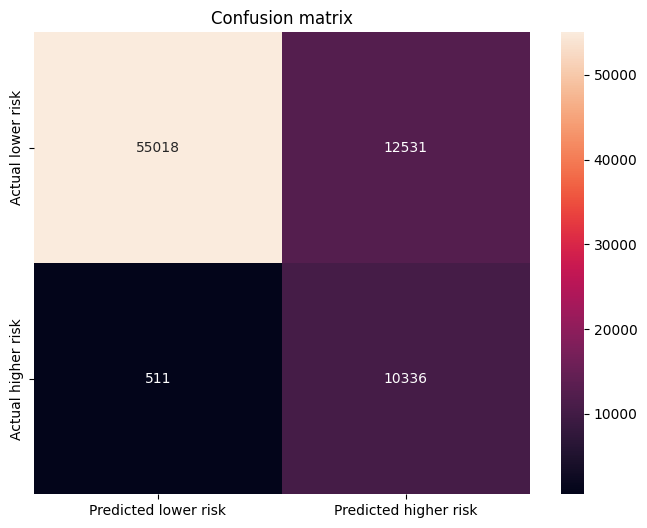

In [48]:
conf_mat = confusion_matrix (yy, y_predictions)
cm_df = pd.DataFrame(conf_mat, columns=["Predicted lower risk", "Predicted higher risk"], index=["Actual lower risk", "Actual higher risk"])
##plot the confusion matrix via seaborn

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.show()


In [49]:
accuracy_score(yy, y_predictions)

0.8336394714016021

In [50]:
recall_score(yy, y_predictions)

0.9528902000553149

# 8. Simulate one-entry

In [51]:
# Define the columns
conditions = [
    'USMER', 'SEX', 'PATIENT_TYPE', 'INTUBED', 'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 
    'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 
    'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU'
]

# Create a dictionary with sample data for each column
data = {
    'USMER': [1], 'SEX': ['Male'], 'PATIENT_TYPE': ['Home'], 'INTUBED': [0.0], 
    'PNEUMONIA': [1.0], 'AGE': [45.0], 'PREGNANT': [0.0], 'DIABETES': [1.0], 'COPD': [0.0], 
    'ASTHMA': [0.0], 'INMSUPR': [1.0], 'HIPERTENSION': [1.0], 'OTHER_DISEASE': [0.0], 
    'CARDIOVASCULAR': [1.0], 'OBESITY': [0.0], 'RENAL_CHRONIC': [0.0], 'TOBACCO': [1.0], 
    'CLASIFFICATION_FINAL': [1], 'ICU': [0.0]
}

# Create the DataFrame
df_one = pd.DataFrame(data, columns=conditions)

# Ensure the data types match those of XTrain
df_one = df_one.astype({
    'USMER': 'int64', 'SEX': 'string', 'PATIENT_TYPE': 'string', 
    'INTUBED': 'float64', 'PNEUMONIA': 'float64', 'AGE': 'float64', 'PREGNANT': 'float64', 
    'DIABETES': 'float64', 'COPD': 'float64', 'ASTHMA': 'float64', 'INMSUPR': 'float64', 
    'HIPERTENSION': 'float64', 'OTHER_DISEASE': 'float64', 'CARDIOVASCULAR': 'float64', 
    'OBESITY': 'float64', 'RENAL_CHRONIC': 'float64', 'TOBACCO': 'float64', 
    'CLASIFFICATION_FINAL': 'int64', 'ICU': 'float64'
})

In [52]:
# Transform the data
df_one_transformed = preprocessor.transform(df_one)

In [53]:
df_one_transformed

array([[ 0.        ,  1.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  1.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         1.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  1.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  1.        ,  0.        ,  0.        , -0.00925322,
         0.        ,  1.        ,  1.        ,  0.        ]])

In [54]:
X_one = pd.DataFrame(df_one_transformed, columns=preprocessor.get_feature_names_out())

In [55]:
X_one

,categorical__USMER_0,categorical__USMER_1,categorical__INTUBED_0.0,categorical__INTUBED_0.5,categorical__INTUBED_1.0,categorical__PNEUMONIA_0.0,categorical__PNEUMONIA_0.5,categorical__PNEUMONIA_1.0,categorical__PREGNANT_0.0,categorical__PREGNANT_0.5,...,categorical__TOBACCO_0.5,categorical__TOBACCO_1.0,categorical__ICU_0.0,categorical__ICU_0.5,categorical__ICU_1.0,numerical__AGE,categorical simple__SEX_Female,categorical simple__SEX_Male,categorical simple__PATIENT_TYPE_Home,categorical simple__PATIENT_TYPE_Hospital
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,-0.009253,0.0,1.0,1.0,0.0


In [56]:
prediction = mlp_final.predict(X_one)
prediction_proba = mlp_final.predict_proba(X_one)

In [57]:
prediction

array([1])

In [58]:
prediction_proba

array([[0.36786455, 0.63213545]])